# Computer Vision

## 1

Иморты

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


Код в блоке ниже уже был в задании 

In [15]:
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

Дописываем функцию [load_dataloaders] с помощью:
- [torchvision.datasets.CIFAR10]
- [torch.utils.data.DataLoader]  
Функция принимает ТЕНЗОРЫ и количество БАТЧЕЙ \
Функция возвращает DataLoaderы для train и test частей датасета. \
C помощью функции `len` выводим количество батчей в train_loader и test_loader.\
Оставляем параметры DataLoader `transform` и `batch_size`  по умолчанию.

In [16]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

   
# root='./data' указывает путь к корневой директории, где будут сохранены данные.
# train=False указывает, что это тестовый набор данных, а не тренировочный.
# download=True указывает, что данные должны быть загружены, если они еще не были скачаны.
# transform=transform указывает список преобразований, которые будут применены к изображениям из набора данных.
    
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# test_set указывает объект набора данных CIFAR-10, который будет использоваться для загрузки данных.
# batch_size=batch_size указывает количество изображений, которые будут загружаться за одну итерацию.
# shuffle=False указывает, что данные не должны быть перемешаны перед загрузкой.
# num_workers=2 указывает количество рабочих процессов, которые будут использоваться для параллельной загрузки данных.    
    
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

train_loader, test_loader = load_dataloaders()
train_batches = len(train_loader)
test_batches = len(test_loader)

print("Количество train batches:", train_batches)
print("Количество of test batches:", test_batches)

100%|██████████| 170498071/170498071 [00:29<00:00, 5798424.30it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Количество train batches: 782
Количество of test batches: 157


## 2


Передаем первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow] и визуализируем датасет


            cat            ship            ship            plane


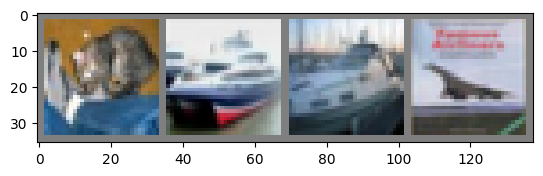

In [4]:
# Функция imshow принимает входные параметры images (изображения) и labels (метки классов) и визуализирует их.

# padding_size=12 - параметр, указывающий размер отступа слева при выводе меток классов.
# labels_split_size=12 - параметр, указывающий размер отступа между метками классов.

def imshow(images, labels, padding_size=12, labels_split_size=12):
    # убрать нормализацию (нормализация обратная к той, которая была применена при нормализации данных при загрузке)
    img = images / 2 + 0.5
    # преобразование изображений в массив NumPy.
    npimg = img.numpy()
    # преобразование меток классов в текстовый формат и объединение их с заданным отступом между метками.
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    # вывод меток классов с заданным отступом слева.
    print(' ' * padding_size + label_text)
    # преобразование массива NumPy в формат изображений и отображение изображений.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))   
    plt.show()

# Получение первого батча тестовой выборки
images, labels = next(iter(test_loader))

imshow(torchvision.utils.make_grid(images[:4]), labels[:4])

## 3

Попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet]. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишим класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться: 
- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), 
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), 
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

In [5]:
#  определение класса ResidualNet, который является подклассом nn.Module и наследует его функциональность.
class ResidualNet(nn.Module):
    
    # конструктор класса, который инициализирует объект ResidualNet. 
    
    def __init__(self, n_classes=10):
        
        # вызывается конструктор родительского класса nn.Module для инициализации объекта ResidualNet.
        
        super(ResidualNet, self).__init__()
        
        # слой свертки 1x1 с 3 входными каналами (RGB изображение) и 32 выходными каналами. 
        # Этот слой используется для изменения размерности тензора входных данных, чтобы его размер 
        # соответствовал размеру выходного тензора из блока residual_block.
        
        self.conv_3 = nn.Conv2d(3, 32, 1)
        
        # определяет атрибут self.residual_block, который является экземпляром класса nn.Sequential 
        
        self.residual_block = nn.Sequential( 
            # сверточный слой, который принимает входной тензор размерности (batch_size, 3, height, width) 
            # и применяет 32 фильтра размером 3x3 с паддингом 1. Этот слой выполняет свертку изображения для извлечения 
            # признаков.
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # слой нормализации пакета, который нормализует активации предыдущего слоя по размерности каналов. 
            # Он помогает стабилизировать обучение и ускорить сходимость.
            nn.BatchNorm2d(32),
            # функция активации ReLU, которая применяет нелинейность к активациям после нормализации пакета.
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)     
        )

        # представляет собой последовательность слоев, которые будут применяться последовательно после блоков 
        # свертки для классификации изображений.
        self.clf = nn.Sequential(
            # функция активации ReLU. Она применяется к активациям после блоков свертки для введения нелинейности.
            nn.ReLU(),
            # слой усреднения (пулинга). Он выполняет операцию усреднения по окну размером 8x8. 
            # Это позволяет снизить пространственные размеры активаций и сжать информацию.
            nn.AvgPool2d(8),
            # слой сглаживания (flatten). Он преобразует входной тензорпутем "разворачивания" пространственных 
            # измерений в одномерное представление. Это необходимо для передачи данных в полносвязный слой.
            nn.Flatten(1),
            # полносвязный слой. Он принимает входной тензор размерности (batch_size, 512) и преобразует его 
            # в тензор размерности (batch_size, n_classes), где n_classes - количество классов в задаче классификации. 
            # Этот слой выполняет линейное преобразование активаций для получения предсказаний по классам.
            nn.Linear(512, n_classes)
        )

    
    # определяет, как данные проходят через модель во время прямого прохода (forward pass).
    def forward(self, x):
        #  входной тензор x проходит через блок свертки
        out = self.residual_block(x)
        # входной тензор x также проходит через сверточный слой self.conv_3 с ядром размером 1x1.
        # Это добавляет побочный путь (shortcut connection), который помогает обучать модель с глубокими сверточными сетями, 
        # предотвращая затухание градиентов.
        out += self.conv_3(x)
        # тензор out, полученный после блока свертки и побочного пути, передается в классификационный блок self.clf
        out = self.clf(out)
        return out

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [6]:
# создается экземпляр модели ResidualNet и сохраняется в переменную net.
net = ResidualNet()
# создается тензор размером 10x3x32x32, заполненный нулями
# выполняется проверка, что размерность выходного тензора равна (10, 10). 
# Если это условие истинно, то программа продолжает своё выполнение без ошибок.
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## 4

 Класс [Trainer] уже был написан в задании

In [7]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):
        
        self.train_loss_log = [] 
        self.train_acc_log = [] 
        self.test_loss_log = []
        self.test_acc_log = []
        
        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")
    
    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

Функция def plot_train_log() уже была написана в задании

In [8]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

Для обучения кроме самой модели требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучим сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируем процесс обучения модели.

Сеть загружена на cuda:0
Epoch 0
 train loss: 88.44209018570687, train acc: 0.5046155690537084
 test loss: 73.01025005510658, test acc: 0.597531847133758

Epoch 1
 train loss: 65.88326855998515, train acc: 0.6400855179028133
 test loss: 63.42556257308669, test acc: 0.6534633757961783

Epoch 2
 train loss: 58.82750533364923, train acc: 0.6807664641943734
 test loss: 59.79154076545861, test acc: 0.676453025477707

Epoch 3
 train loss: 54.584806695923476, train acc: 0.703065057544757
 test loss: 58.44679176427756, test acc: 0.6786425159235668

Epoch 4
 train loss: 51.838533058800664, train acc: 0.719309462915601
 test loss: 52.49928163419104, test acc: 0.7140724522292994



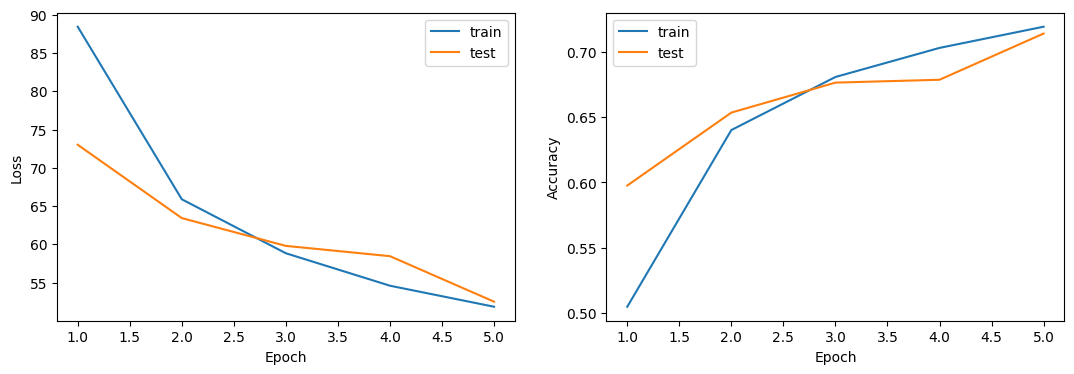

In [9]:
# Задаем гиперпараметры
learning_rate = 0.1 # 0.1
num_epochs = 5 # 5

# Создаем модель
model = ResidualNet(n_classes=10)

# Определяем оптимизатор и функцию ошибок
# momentum - коэффициент момента, который учитывает предыдущие обновления при вычислении новых обновлений параметров.
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Эта функция предназначена для задачи классификации с множеством классов. 
# Она вычисляет потери между прогнозами модели и истинными метками, используя кросс-энтропийную функцию потерь.
criterion = nn.CrossEntropyLoss()

# Создаем экземпляр класса Trainer
trainer = Trainer(model, optimizer, criterion)

torch.autograd.set_detect_anomaly(True)

# Обучаем модель
trainer.train(train_loader, test_loader, num_epochs)
# Визуализируем процесс обучения
plot_train_log(trainer)


## 5

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [10]:
transform_v2 = transforms.Compose(
    [
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация данных
    ]
)
BATCH_SIZ = 64 # Количество изображений в Батче
CLASSE = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [11]:
def load_dataloaders(transform_v2 = transform_v2, batch_size = BATCH_SIZ):
    train_set_v2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform_v2)
    train_loader_v2 = torch.utils.data.DataLoader(train_set_v2, batch_size=batch_size, shuffle=True, num_workers=2)

    test_set_v2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform_v2)
    test_loader_v2 = torch.utils.data.DataLoader(test_set_v2, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader_v2, test_loader_v2

train_loader_v2, test_loader_v2 = load_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


            cat            ship            ship            plane


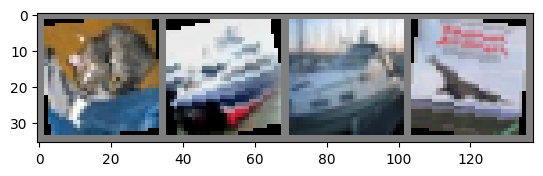

In [12]:
def imshow(images_v2, labels_v2, padding_size=12, labels_split_size=12):
    # убрать нормализацию
    img = images_v2 / 2 + 0.5
    npimg = img.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSE[j]) for j in labels_v2.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Получение первого батча тестовой выборки
images_v2, labels_v2 = next(iter(test_loader_v2))

imshow(torchvision.utils.make_grid(images_v2[:4]), labels_v2[:4])

Сеть загружена на cuda:0
Epoch 0
 train loss: 93.44027073608945, train acc: 0.4741048593350384
 test loss: 81.6579644998927, test acc: 0.548765923566879

Epoch 1
 train loss: 74.90157623730047, train acc: 0.5852381713554987
 test loss: 67.88913553079982, test acc: 0.6232085987261147

Epoch 2
 train loss: 67.01586351370263, train acc: 0.6308943414322251
 test loss: 75.83143147997036, test acc: 0.5846934713375797

Epoch 3
 train loss: 63.08352533935586, train acc: 0.6551110933503836
 test loss: 65.53078222578498, test acc: 0.6451035031847133

Epoch 4
 train loss: 59.7295401078051, train acc: 0.6743526214833759
 test loss: 61.152273493967236, test acc: 0.6655055732484076

Epoch 5
 train loss: 58.56076175050662, train acc: 0.6782289002557544
 test loss: 58.19501034317503, test acc: 0.6804339171974523



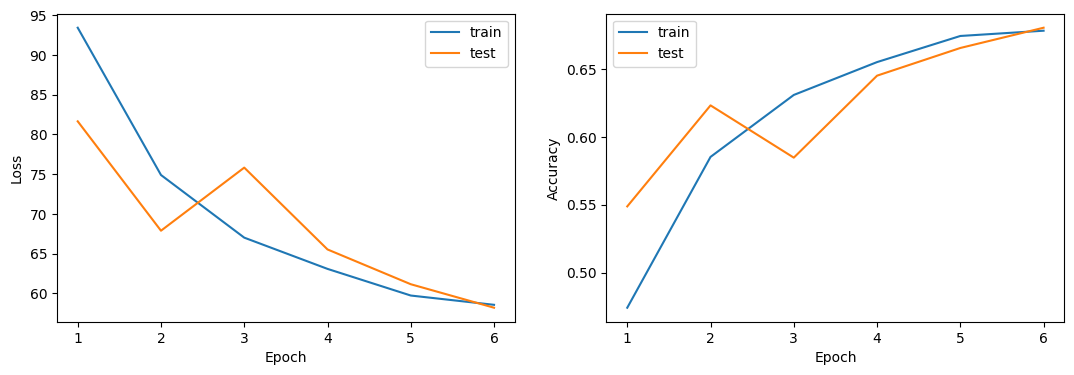

In [13]:
# Задаем гиперпараметры
learning_rate = 0.09 # 0.09
num_epochs = 6 # 6

# Создаем модель
model = ResidualNet(n_classes=10)

# Определяем оптимизатор и функцию ошибок
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Создаем экземпляр класса Trainer
trainer_v2 = Trainer(model, optimizer, criterion)

# Обучаем модель
trainer_v2.train(train_loader_v2, test_loader_v2, num_epochs)
# Визуализируем процесс обучения
plot_train_log(trainer_v2)